# In this notebook, I will describe how to use variation of parameters to estimate a slater-type orbital as a linear combination of gaussian-type orbitals
## Specifically, I will consider the caes of a hydrogen atom

### Previous work:
Thankfully, the overlap $S$ matrix, as well as the kinetic energy $T$ matrix and the coulomb potential energy $V$ matrix has been calculated for me in terms of the standard deviations of these gaussians:
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\begin{align*}
S_{pq} &= \left ( \frac{\pi}{\alpha_p + \alpha_q} \right ) ^ {3/2}\\
T_{pq} &= 3 \frac{\alpha_p \alpha_q \pi^{3/2}}{\left(\alpha_p + \alpha_q\right)^{5/2}}\\
V_{pq} &= -\frac{2\pi}{\alpha_p + \alpha_q}
\end{align*}$$

### My work:
The slater-type orbital we would like to approximate is represented as a linear combination of the gaussian type orbitals:
$$
\begin{align*}
\ket{s} &= \displaystyle\sum_i C_i \ket{i}\\
\ket{i} &= \exp\left(\alpha_i r^2\right)
\end{align*}
$$
It remains to optimize the values of the coefficients $C_i$ and the parameters in the gaussians $\alpha_i$. I will do this with gradient descent.

### How it works:
The variational principle states that for any state with a variational parameter, nature will choose the value of that parameter that *minimizes* the energy. Thus, to optimize the linear combination of gaussians to most faithfully represent the slater-type orbital, the energy of this linear combination of gaussians must be minimized. This reduces the quantum mechanics problem to a more abstract optimization problem.

In [1]:
#First, I import the necessary libraries and set constants with regards to the learning parameters
import numpy as np
import math

PI_3_2 = math.pi ** 1.5
N = 3 #number of terms used in linear combination

#These can be tuned; I just found that these values work well.
ALPHA_LEARNING_RATE = 0.1
COEFF_LEARNING_RATE = 0.1
DELTA_A = 10 ** -6
DELTA_C = 10 ** -6

NUM_ITERS = 10 ** 6

Then, I set up the functions for calculating the energy as described above. It is important to note here that the energy of a linear combination of states is defined as:
$$
\begin{equation*}
E_\psi = \frac{\bra{\psi} \hat{H} \ket{\psi}}{\bra{\psi}\ket{\psi}}
\end{equation*}
$$

In [2]:
def calc_overlap(ap, aq):
    return PI_3_2 / ((ap + aq) ** 1.5)

def calc_KE(ap, aq):
    return 3 * PI_3_2 * (ap * aq) / (ap + aq) ** 2.5

def calc_PE(ap, aq):
    return -2 * math.pi / (ap + aq)

def calc_single_E(ap, aq):
    return calc_KE(ap, aq) + calc_PE(ap, aq)

def calc_norm(c, a):
    n = len(c) #Used here because further down the line I use approximations w/ different values of N
    o = 0
    for i in range(n):
        for j in range(n):
            o += c[i] * c[j] * calc_overlap(a[i], a[j])
    return o

def calc_composite_E(c, a):
     n = len(c) #Used here because further down the line I use approximations w/ different values of N
     E = 0
     for i in range(n):
         for j in range(n):
             E += c[i] * c[j] * calc_single_E(a[i], a[j])
     return E / calc_norm(c, a)

Now, I will implement the gradient descent algorithm. How it works is it calculates the direction of steepest descent for each of the parameters (each value of $\alpha$ and $C$) using a crude method of calculating the derivative (simply taking the slope of the local secant line as the slope of the tangent line). It then adjusts them in that direction an amount scaled by the learning rate parameters. Note: if alpha ever goes negative, the gaussian it represents now blows up to infinity, and it no longer represents a physical state. This would break all physical sense and all our calculations, so to prevent this from happening, I scale the change to alpha by the value of alpha itself. This way, it will never subtract something greater than alpha from alpha, keeping its value always positive.

In [3]:
def step(c, a):
    #Vary the parameters to see the direction of steepest descent.
    #Start with alphas and then move on to coefficients
    E_0 = calc_composite_E(c, a)
    #Computing alphas
    gradients_a = []
    gradients_c = []
    for i in range(N):
        a[i] += DELTA_A
        gradients_a.append((calc_composite_E(c, a) - E_0) / DELTA_A)
        a[i] -= DELTA_A
    for i in range(N):
        c[i] += DELTA_C
        gradients_c.append((calc_composite_E(c, a) - E_0) / DELTA_C)
        c[i] -= DELTA_C
    a -= gradients_a * a # scaled by the alpha values so they never go negative
    c -= gradients_c
    return c, a

Now, I assign random values to the starting parameters, and let the code run!

In [4]:
c = np.random.rand(N)
a = np.random.rand(N)

for i in range(NUM_ITERS):
    c, a = step(c, a)
    if i % int(NUM_ITERS / 10) == 0:
        print("Coefficients:", c)
        print("Alpha values:", a) 
        print("Energy:", calc_composite_E(c, a))
        print()
print("Coefficients:", c)
print("Alpha values:", a) 
print("Energy:", calc_composite_E(c, a))

Coefficients: [0.78308563 0.91765503 0.73183162]
Alpha values: [0.12699343 0.64524172 0.60112596]
Energy: -0.4734022571375189

Coefficients: [0.54158995 0.75036815 1.05396934]
Alpha values: [0.15137117 4.50014988 0.68125867]
Energy: -0.4969792526866915

Coefficients: [0.53778255 0.74509306 1.04655993]
Alpha values: [0.15137117 4.50014978 0.68125865]
Energy: -0.49697925268666854

Coefficients: [0.53392045 0.73974219 1.03904408]
Alpha values: [0.15137117 4.50014968 0.68125863]
Energy: -0.4969792526866449

Coefficients: [0.53000165 0.73431276 1.03141788]
Alpha values: [0.15137116 4.50014955 0.68125861]
Energy: -0.49697925268661886

Coefficients: [0.52602405 0.72880188 1.02367726]
Alpha values: [0.15137116 4.50014941 0.68125859]
Energy: -0.4969792526865915

Coefficients: [0.52198538 0.72320637 1.01581778]
Alpha values: [0.15137116 4.5001493  0.68125857]
Energy: -0.4969792526865657

Coefficients: [0.5178832  0.71752288 1.00783473]
Alpha values: [0.15137115 4.50014916 0.68125855]
Energy: -0.

The values should converge to -0.5, as that is the theoretical limit, as determined without using approximations. Note: re-running the program will produce slightly different results, since the initial parameters are randomly set.

To make this a completely physical state, it still has to be well normalized. This doesn't affect the energy, meaning we can just normalize at the end and we're done.

In [5]:
c /= math.sqrt(calc_norm(c, a))
calc_composite_E(c, a) #Verify that the energy hasn't changed

-0.4969792526864479

Now, to see visually what this approximation looks like, I will plot the approximated curve given by the linear combination of gaussians as well as the slater orbital on the same axes. The slater orbital is given by:
$$
\begin{equation*}
R_s(r) = \frac{1}{\sqrt{\pi}} \left (\frac{1}{a_0} \right) ^ {3/2} e^{-r/a_0}
\end{equation*}
$$
Note: For the purposes of this calculation, we have taken the Bohr radius to be unity ($a_0 = 1$), just to make the math easier.

Text(0.5, 1.0, 'Comparing the true Slater-type orbital with our approximation of it')

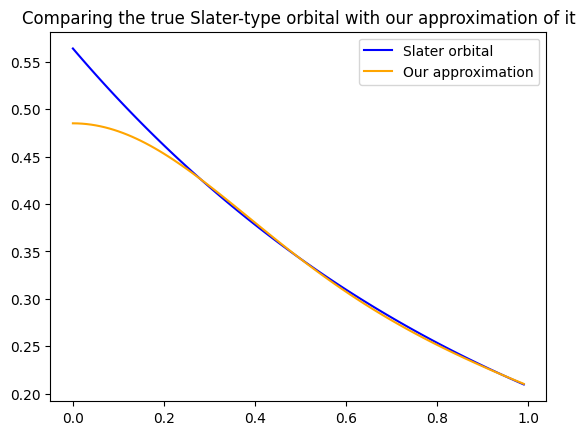

In [6]:
x = np.arange(0, 1, 10 ** -2)
y = math.e ** (- x)  / math.sqrt(math.pi)
approx = lambda x : sum((c[i] * math.e ** (- a[i] * x ** 2) for i in range(N)))
approx = np.vectorize(approx)
y_approx = approx(x)

# importing the required module
import matplotlib.pyplot as plt

plt.plot(x, y, color="blue", label="Slater orbital")
plt.plot(x, y_approx, color="orange", label="Our approximation")
plt.legend()
plt.title("Comparing the true Slater-type orbital with our approximation of it")

Now I wish to show the improvement of the results as we use more and more gaussians. I will go with 100,000 iterations, and start with 1 gaussian, through 6, to estimate the Slater-type orbital.

Text(0.5, 1.0, 'Comparing true Slater orbital  with linear combinations of gaussians approximating it')

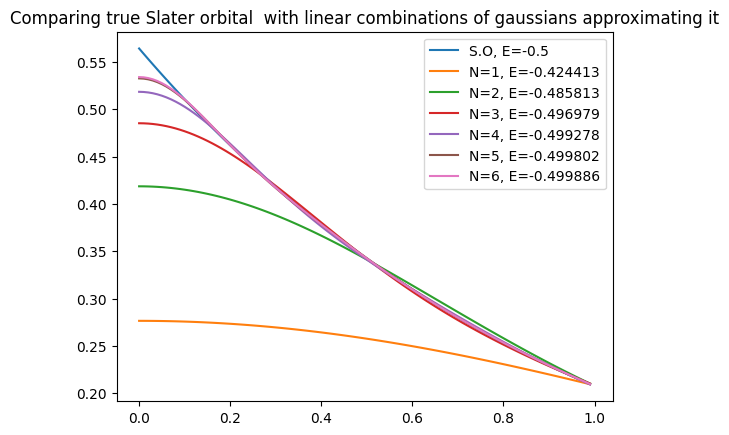

In [7]:
#Using previously computed results:
c_s = [[0.2764921], #N=1
       [0.17604534, 0.24254945], #N=2
       [0.11201836, 0.21799509, 0.15520052], #N=3
       [0.18558638, 0.16303154, 0.07368489, 0.09610477], #N=4
       [0.04607134, 0.11187046, 0.06528639, 0.14902726, 0.16034309], #N=5
       [0.09688989, 0.02078187, 0.08990897, 0.05876608, 0.12594956, 0.14168277]] #N=6

a_s = [[0.28294162], #N=1
       [0.2015276,  1.33248267], #N=2
       [0.15137115, 0.68125851, 4.50014897], #N=3
       [0.44446756, 1.9619103,  0.12193537,  13.00824831], #N=4
       [0.09980961, 4.44459832, 27.38647639, 0.30933495,  1.06398693], #N=5
       [0.19686404, 0.07617633, 5.7552382,   30.85191908, 1.60100871, 0.53322117]] #N=6

#Clear the plot
plt.cla()

#Plot the true slater orbital
x = np.arange(0, 1, 10 ** -2)
y = math.e ** (- x)  / math.sqrt(math.pi)
plt.plot(x, y, label="S.O, E=-0.5")

#I used 1-6 estimators
for n in range(6):
    approx = lambda q : sum((c_s[n][i] * math.e ** (- a_s[n][i] * q ** 2) for i in range(n + 1)))
    approx = np.vectorize(approx)
    plt.plot(x, approx(x), label="N={}, E={:.6f}".format(n + 1, calc_composite_E(c_s[n], a_s[n])))

#Add legend & title
plt.legend()
plt.title("Comparing true Slater orbital  with linear combinations of gaussians approximating it")